# Preliminary Arbitrage/Liquidation ABS for ETH Market

This script:
- Generates a random/reasonable borrower distribution
- Generates a GBM price curve for the collateral/USD price
- Runs an agent based simulation where a liquidator agent hard liquidates positions and arbitrages LLAMMA when doing so is profitable. We incorporate a naive external slippage curve to account for market impact on external spot exchanges (i.e. Uniswap).
- Outputs metrics related to the simulation:
    - System health
    - Hard liquidation PnL
    - Arbitrage PnL

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.modules.llamma import LLAMMA
from src.modules.controller import Controller
from src.modules.oracle import Oracle
from src.modules.mpolicy import MonetaryPolicy
from src.agents.liquidator import Liquidator
from src.sim.pricegenerator import PriceGenerator

import copy
import imageio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from datetime import datetime
from src.utils.plotting import *
from src.utils import external_swap

In [3]:
WINDOW = 600  # 10 minutes
BASE_PRICE = 1800
A = 100
FEE = 0.006
ADMIN_FEE = 1
LOAN_DISCOUNT = 0.09
LIQUIDATION_DISCOUNT = 0.06

N_BORROWERS = 100
VALUE = 60_000_000  # USD value of collateral
COINS = 60_000_000 / BASE_PRICE  # Number of collateral coins
DEBT = 44_000_000  # crvUSD debt

TOLERANCE = 0  # Min profit for liquidator to act

# START = int(datetime.now().timestamp())
START = 1697675181

# For plotting/gifs
FPS = 3

oracle = Oracle(WINDOW)
oracle.update(START, BASE_PRICE)  # set initial price
llamma = LLAMMA(A, BASE_PRICE, oracle, FEE, admin_fee=ADMIN_FEE)
mpolicy = MonetaryPolicy()
controller = Controller(llamma, mpolicy, LOAN_DISCOUNT, LIQUIDATION_DISCOUNT)
liquidator = Liquidator(TOLERANCE, verbose=True)

## Generate borrower distribution

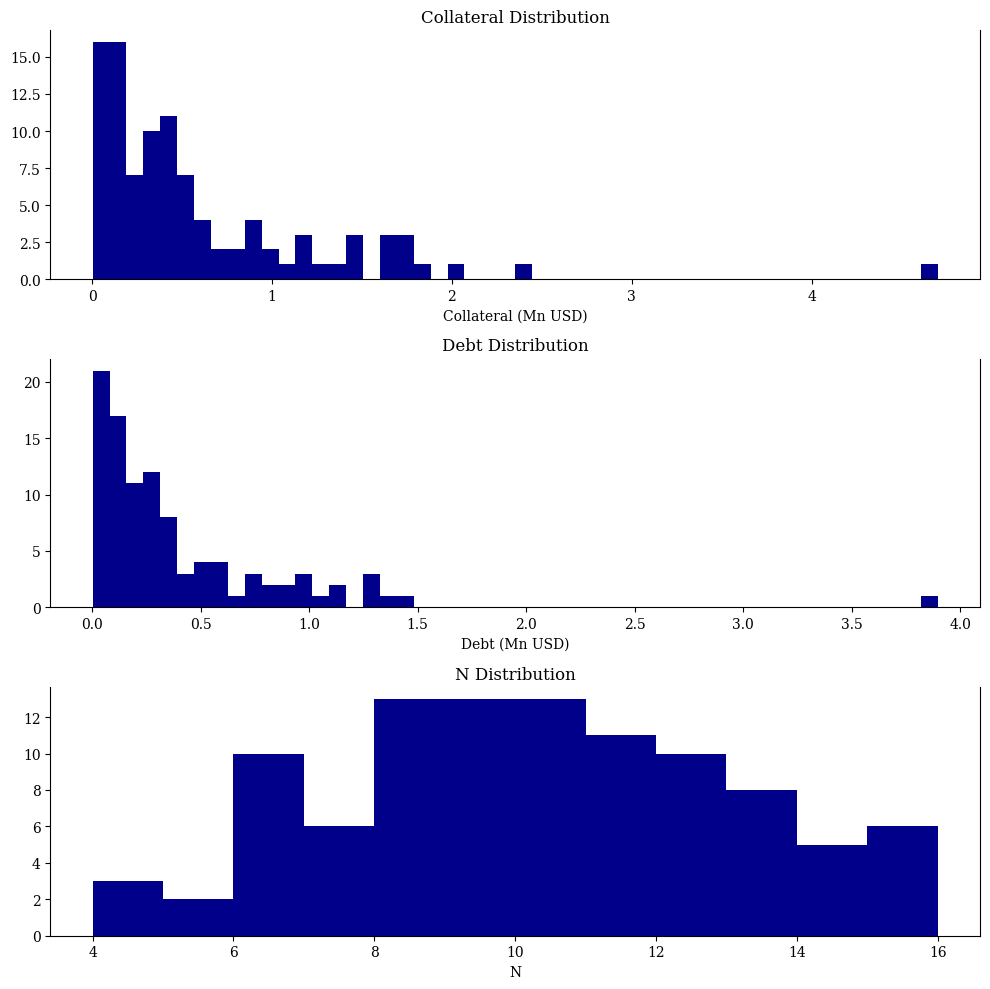

In [4]:
# borrowers = controller.gen_borrowers(N_BORROWERS, COINS, v=True)
# np.save("../data/borrowers.npy", borrowers)
borrowers = np.load("../data/borrowers.npy")
plot_borrowers(borrowers, BASE_PRICE, fn="../figs/manual/borrowers.png")

Initial system health: 0.3820759394949393


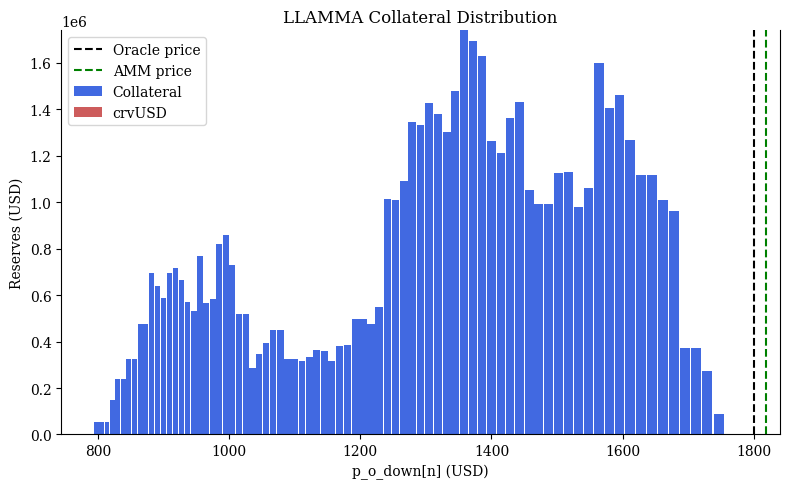

In [5]:
for i, b in enumerate(borrowers):
    # Deposit!
    controller.create_loan(i, *b)
print(f"Initial system health: {controller.system_health}")
llamma._plot_reserves()

In [6]:
# TODO Will want other metrics to be satisfied as well: e.g., incorporate LTV, # of bands, and check that it's correct
# Check that this generate func will generally give us ~ the expected debt
# debts = []
# for _ in range(1000):
#     bs = controller.gen_borrowers(N_BORROWERS, COINS)
#     debts.append(bs[:,1].sum())
# print(f"Mean debt: {round(np.mean(debts) / 1e6)} Mns USD")
# print(f"Desired debt: {DEBT / 1e6} Mns USD")

## Run Simulation

,timestamp,spot,oracle,liquidation_pnl,arbitrage_pnl,system_health,liquidation_count,arbitrage_count,bad_debt
datetime,,,,,,,,,
2023-10-19 00:26:21,1697675181,1800.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 01:26:21,1697678781,1621.595528,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 02:26:21,1697682381,1562.490389,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 03:26:21,1697685981,1529.652174,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-10-19 04:26:21,1697689581,1534.929242,0.0,0.0,0.0,0.0,0.0,0.0,0.0


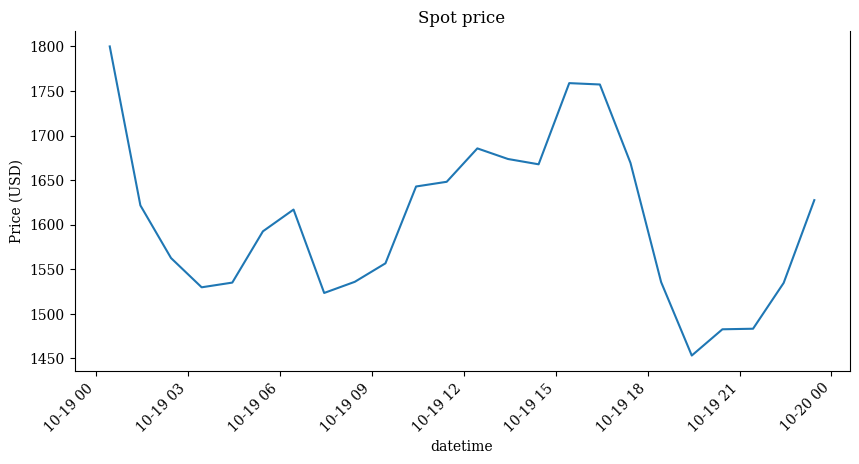

In [7]:
# TODO other metrics: admin_fees, total gains and losses (arb_pnl + liq_pnl + admin_fees)
# TODO pnl is accounting for gas/slippage on external venues, so it's not exactly pnl for the system.
# Example: +10 pnl for a liquidator might actually be -15 pnl for the system.
# TODO test fees going to users

PERIOD = 86400  # 1 day
WINDOW = 60 * 60
nobs = PERIOD // WINDOW


def gen_test_df(fn="../data/tmp3.csv"):
    times = [START] + [int(START + dt * WINDOW) for dt in range(1, nobs)]
    df = pd.DataFrame(
        columns=[
            "timestamp",
            "spot",
            "oracle",
            "liquidation_pnl",
            "liquidation_count",
            "arbitrage_pnl",
            "arbitrage_count",
            "system_health",
            "bad_debt",
        ]
    )
    df["timestamp"] = times
    df.index = pd.to_datetime(df["timestamp"], unit="s")
    df.index.name = "datetime"
    pg = PriceGenerator()
    df["spot"] = np.concatenate(
        [
            [BASE_PRICE],
            pg.gen_single_gbm(S0=BASE_PRICE, mu=-0.1, sigma=0.05, dt=1 / nobs, T=1)[1:],
        ]
    )
    # Caching because I like this price curve for testing
    df.to_csv(fn)
    return df


def read_test_df(fn="../data/tmp.csv"):
    df = pd.read_csv(fn, index_col=0)
    df.index = pd.to_datetime(df.index)
    return df


df_user = pd.DataFrame()  # to track any user data

df = read_test_df(fn="../data/tmp.csv")
# df = gen_test_df(fn='../data/tmp5.csv')
df["spot"].plot(
    rot=45,
    figsize=(10, 5),
    title="Spot price",
    ylabel="Price (USD)",
)
plt.savefig("../figs/manual/prices_fast.png")
df = df.astype(float)
df["timestamp"] = df["timestamp"].astype(int)
df.head()

In [8]:
# fast = read_test_df(fn='../data/tmp.csv')['spot']
# slow = read_test_df(fn='../data/tmp5.csv')['spot']
# f, ax = plt.subplots(figsize=(8, 5))
# ax.plot(fast, lw=1, c='indianred', label='High Volatility')
# ax.plot(slow, lw=1, c='royalblue', label='Low Volatility')
# ax.tick_params(axis='x', rotation=45)
# ax.legend()
# ax.set_ylabel('Price (USD)')
# ax.set_title('Simulated Collateral Price Paths')
# f.tight_layout()
# plt.savefig('../figs/manual/fast_slow.png', dpi=300)

In [9]:
max_y = df["spot"].max() * max(llamma.bands_y.values())

# Init external market liquidity for slippage calc
ext_stable_liquidity = 2e10  # NOTE why 2M?
ext_collat_liquidity = ext_stable_liquidity / BASE_PRICE
ext_swap_fee = 0.0005

user = 69  # NOTE user of interest

# Run simulation
frame = 0
for i, row in df.iterrows():
    fn = fn_frames_reserves.format(frame)

    # Update oracle
    ema_price = oracle.update(row["timestamp"], row["spot"])
    df.loc[i, "oracle"] = ema_price

    print(f"\nNew Step: {i}\n-----------------------\n")
    print(f"Oracle Price: {ema_price}")

    # Update external liquidity
    ext_collat_liquidity = ext_stable_liquidity / row["spot"]

    # TODO really a liquidator would do the most profitable combination

    if i == datetime.fromisoformat("2023-10-19 05:26:21"):
        llamma_cp = copy.deepcopy(llamma)

    # Track user of interest
    if user in controller.loans:
        df_user.loc[i, "Debt"] = controller.loans[user]
        df_user.loc[i, "Health"] = controller.health(user, full=True)
        df_user.loc[i, "Sum x"], df_user.loc[i, "Sum y"] = llamma.get_sum_xy(user)
        df_user.loc[i, "x_down"] = llamma.get_x_down(user)
        df_user.loc[i, "x_down2"] = llamma.get_x_down2(user)
        # df_user.loc[i, 'bands'] = np.array(llamma.user_shares[user].keys())
        df_user.loc[i, "band"] = llamma.active_band
        df_user.loc[i, "p"] = llamma.p

    # Check for liquidations
    liquidation_pnl, bad_debt = liquidator.perform_liquidations(
        controller, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee
    )

    # Check for arbitrage
    arbitrage_pnl = liquidator.arbitrage(
        llamma, row["spot"], ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee
    )

    # Track metrics
    df.loc[i, "p_amm"] = llamma.p
    df.loc[i, "liquidation_pnl"] = liquidation_pnl
    df.loc[i, "liquidation_count"] = liquidator.liquidation_count
    df.loc[i, "arbitrage_pnl"] = arbitrage_pnl
    df.loc[i, "arbitrage_count"] = liquidator.arbitrage_count
    df.loc[i, "system_health"] = controller.system_health
    df.loc[i, "bad_debt"] = bad_debt

    # For GIF
#     plot_reserves(llamma, fn, max_y=max_y)
#     frame += 1

# frames = [imageio.v2.imread(fn_frames_reserves.format(i)) for i in range(len(df))]
# imageio.mimsave(fn_gif_reserves, frames, fps=FPS)
# plot_sim(df)
# plot_combined('../figs/gifs/combined5.gif')


New Step: 2023-10-19 00:26:21
-----------------------

Oracle Price: 1800

New Step: 2023-10-19 01:26:21
-----------------------

Oracle Price: 1622.037748284333
Liquidated user 0 with pnl 334071.7805259889.
Liquidated user 3 with pnl 10514.367273726588.
Liquidated user 24 with pnl 9050.91902019913.
Liquidated user 28 with pnl 19634.909157482092.
Liquidated user 42 with pnl 11502.988865289604.
Liquidated user 43 with pnl 4259.573887701146.
Liquidated user 54 with pnl 27032.389859034796.
Liquidated user 66 with pnl 1807.6437151433056.
Liquidated user 81 with pnl 19529.58564750728.
Performed arbitrage, profit: 16440 USD

New Step: 2023-10-19 02:26:21
-----------------------

Oracle Price: 1562.6379920857596
Liquidated user 44 with pnl 92622.3331890516.
Liquidated user 50 with pnl 67992.69635727268.
Liquidated user 88 with pnl 144.64391680588005.
Liquidated user 89 with pnl 789.425949070308.
Liquidated user 99 with pnl 32120.173474405485.
Performed arbitrage, profit: 37568 USD

New Step:

In [14]:
llamma_cp.active_band

15

In [17]:
llamma_cp.p_o_down(15)

1532.623987970776

## Tracking Metrics

So far we have seen what the reserves look like over time and what actions the liquidator agent is taking (arbitrage, liquidate). There are other key metrics we want to track:

- System health
- Underwater debt
- "Bad debt" <- define this better
- Unnecessary liquidations <- define this better (e.g. liquidations triggered by arbitrage)
- Borrower losses

## Investigating User 69

User 69 gets liquidated when the price increases between 4:30am and 5:30am on October 19th (simulated data). This is counterintuitive; does it mean our simulations are wrong? We track user 69's behavior in the below DataFrame. Notice that when the price increases from 4 to 5am, the user gets "de-liquidated" as their position gets converted back to being fully collateral. However, throughout the 7 timesteps, the user gets soft liquidated/de-liquidated 3 times, resulting in a loss of 30 ETH. Following the final de-liquidation, this puts them below the acceptable margin requirement (health), leading to a hard liquidation.

The problem is clear: LVR leads to hard liquidations. However, losing 30 ETH (approx 3%) of their position due to arbitrage seems extreme. Are we overestimating arbitrageur profits?

The pipeline of: price volatility -> arbitrage -> LVR -> hard liquidations or even missed liquidations seems clear though, we will likely want to investigate.

In [10]:
df_user = df_user.join(df[["spot", "oracle"]])
df_user["Collateral Value"] = df_user["Sum x"] + df_user["Sum y"] * df_user["spot"]
# df_user = df_user[['Debt', 'Sum x', 'Sum y', 'Collateral Value', 'Health', 'spot']]
df_user

,Debt,Health,Sum x,Sum y,x_down,x_down2,band,p,spot,oracle,Collateral Value
2023-10-19 00:26:21,1.305477e+06,0.181954,0.000000e+00,940.833034,1.420847e+06,1.420847e+06,0.0,1818.181818,1800.000000,1800.000000,1.693499e+06
2023-10-19 01:26:21,1.305477e+06,0.053700,0.000000e+00,940.833034,1.420847e+06,1.420847e+06,0.0,1330.462585,1621.595528,1622.037748,1.525651e+06
2023-10-19 02:26:21,1.305477e+06,0.021046,-7.424764e-20,940.833034,1.418034e+06,1.418034e+06,10.0,1441.469019,1562.490389,1562.637992,1.470043e+06
2023-10-19 03:26:21,1.305477e+06,0.011028,1.215729e+05,861.941240,1.404122e+06,1.404122e+06,13.0,1457.032133,1529.652174,1529.733938,1.440043e+06
2023-10-19 04:26:21,1.305477e+06,0.011151,4.577641e+05,636.127900,1.404292e+06,1.404292e+06,15.0,1536.840586,1534.929242,1534.916364,1.434175e+06
2023-10-19 05:26:21,1.305477e+06,-0.010431,4.577641e+05,636.127900,1.374319e+06,1.374319e+06,15.0,1715.575711,1592.491513,1592.348798,1.470792e+06


In [11]:
print(df_user.to_latex(float_format=f"{{:0.2f}}".format))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & Debt & Health & Sum x & Sum y & x_down & x_down2 & band & p & spot & oracle & Collateral Value \\
\midrule
2023-10-19 00:26:21 & 1305477.37 & 0.18 & 0.00 & 940.83 & 1420846.57 & 1420846.57 & 0.00 & 1818.18 & 1800.00 & 1800.00 & 1693499.46 \\
2023-10-19 01:26:21 & 1305477.37 & 0.05 & 0.00 & 940.83 & 1420846.57 & 1420846.57 & 0.00 & 1330.46 & 1621.60 & 1622.04 & 1525650.64 \\
2023-10-19 02:26:21 & 1305477.37 & 0.02 & -0.00 & 940.83 & 1418033.87 & 1418033.87 & 10.00 & 1441.47 & 1562.49 & 1562.64 & 1470042.57 \\
2023-10-19 03:26:21 & 1305477.37 & 0.01 & 121572.92 & 861.94 & 1404121.84 & 1404121.84 & 13.00 & 1457.03 & 1529.65 & 1529.73 & 1440043.21 \\
2023-10-19 04:26:21 & 1305477.37 & 0.01 & 457764.14 & 636.13 & 1404291.63 & 1404291.63 & 15.00 & 1536.84 & 1534.93 & 1534.92 & 1434175.46 \\
2023-10-19 05:26:21 & 1305477.37 & -0.01 & 457764.14 & 636.13 & 1374318.73 & 1374318.73 & 15.00 & 1715.58 & 1592.49 & 1592.35 & 1470792.42 \\
\bottomrule
\end{tab